In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content
# Install mmcv
!pip install mmcv -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html
# Clone mmcls repository
!git clone https://github.com/open-mmlab/mmclassification.git
%cd mmclassification/
# Install MMClassification from source
!pip install -e . 

In [ ]:
# Check MMClassification installation
import torch, torchvision
import mmcls
import mmcv
from mmcls.apis import inference_model, init_model, show_result_pyplot
from mmcv import Config
from mmcls.apis import set_random_seed
import time
import os.path as osp
from mmcls.datasets import build_dataset
from mmcls.models import build_classifier
from mmcls.apis import train_model
import gc
print(mmcls.__version__)

In [ ]:
def create_model(config_file,checkpoint_file,datasetpath,epochs=3,train_cfg=None):
  # Load the base config file
  cfg = Config.fromfile(config_file)

  # Modify the number of classes in the head.
  cfg.model.head.num_classes = 3

  # if custom train cfg defined ( for swin transformers we must define it)
  if train_cfg!=None:
    cfg.model.train_cfg=train_cfg

  cfg.model.head.topk = (1, )

  # Load the pre-trained model's checkpoint.
  cfg.model.backbone.init_cfg = dict(type='Pretrained', checkpoint=checkpoint_file, prefix='backbone')

  # Specify sample size and number of workers.
  cfg.data.samples_per_gpu = 8
  cfg.data.workers_per_gpu = 2

  # Specify the path and meta files of training dataset
  cfg.data.train.data_prefix = datasetpath+'/train_set/train_set'
  cfg.data.train.classes = datasetpath+'/clasess.txt'

  # Specify the path and meta files of validation dataset
  cfg.data.val.data_prefix = datasetpath+'/val_set/val_set'
  cfg.data.val.ann_file = datasetpath+'/val.txt'
  cfg.data.val.classes = datasetpath+'/clasess.txt'

  # Specify the path and meta files of test dataset
  cfg.data.test.data_prefix = datasetpath+'/test_set/test_set'
  cfg.data.test.ann_file = datasetpath+'/test.txt'
  cfg.data.test.classes = datasetpath+'/clasess.txt'


  # Modify the evaluation metric
  cfg.evaluation['metric_options']={'topk': (1, )}

  # Specify the optimizer
  cfg.optimizer = dict(type='SGD', lr=0.005, momentum=0.9, weight_decay=0.0001)
  cfg.optimizer_config = dict(grad_clip=None)

  # Specify the learning rate scheduler
  cfg.lr_config = dict(policy='step', step=1, gamma=0.1)
  cfg.runner = dict(type='EpochBasedRunner', max_epochs=epochs)

  # Specify the work directory
  cfg.work_dir = './work_dirs/Covid19-dataset'

  # Output logs for every 10 iterations
  cfg.log_config.interval = 10

  # Set the random seed and enable the deterministic option of cuDNN
  # to keep the results' reproducible.
  
  cfg.seed = 0
  set_random_seed(0, deterministic=True)

  cfg.gpu_ids = range(1)
  return cfg

In [ ]:
def train(cfg):
  # Create the work directory
  mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
  # Build the classifier
  model = build_classifier(cfg.model)
  model.init_weights()
  # Build the dataset
  datasets = [build_dataset(cfg.data.train)]
  # Add `CLASSES` attributes to help visualization
  model.CLASSES = datasets[0].CLASSES
  # Start fine-tuning
  train_model(
      model,
      datasets,
      cfg,
      distributed=False,
      validate=True,
      timestamp=time.strftime('%Y%m%d_%H%M%S', time.localtime()),
      meta=dict())
  gc.collect()


# Efficient-net

In [ ]:
cfg_model_efficientnet=create_model(config_file='configs/efficientnet/efficientnet-b0_8xb32_in1k.py',
                       checkpoint_file='https://download.openmmlab.com/mmclassification/v0/efficientnet/efficientnet-b0_3rdparty_8xb32_in1k_20220119-a7e2a0b1.pth',
                       datasetpath='/content/drive/MyDrive/test_data/Covid19-dataset/Covid19-dataset',
                       epochs=30
)
train(cfg=cfg_model_efficientnet)

# Vision transformer

In [ ]:
cfg_model_vision=create_model(config_file='configs/vision_transformer/vit-base-p16_ft-64xb64_in1k-384.py',
                       checkpoint_file='https://download.openmmlab.com/mmclassification/v0/vit/finetune/vit-base-p16_in21k-pre-3rdparty_ft-64xb64_in1k-384_20210928-98e8652b.pth',
                       datasetpath='/content/drive/MyDrive/test_data/Covid19-dataset/Covid19-dataset',
                       epochs=30
)
train(cfg=cfg_model_vision)

# Swin transformer

In [ ]:
cfg_model_swin=create_model(config_file='configs/swin_transformer/swin-small_16xb64_in1k.py',
                       checkpoint_file='https://download.openmmlab.com/mmclassification/v0/swin-transformer/convert/swin_small_patch4_window7_224-cc7a01c9.pth',
                       datasetpath='/content/drive/MyDrive/test_data/Covid19-dataset/Covid19-dataset',
                       epochs=30,
                       train_cfg=dict(augments=[
                                      dict(type='BatchMixup', alpha=0.8, num_classes=3, prob=0.5),
                                      dict(type='BatchCutMix', alpha=1.0, num_classes=3, prob=0.5)
                                      ])
)
train(cfg=cfg_model_swin)

# regular CNN and others 

## Reading data

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob

In [ ]:
def get_classes(path):
  classes={}
  index=0
  for clas in glob.glob(path+"/*"):
    classes[ clas.split("/")[-1] ] = index
    index+=1

  return classes

def load_data(path,classes):
  x=[]
  y=[]
  for clas in glob.glob(path+"/*"):
    img_class=clas.split("/")[-1]

    for imgpath in glob.glob(clas+"/*.jpg")+glob.glob(clas+"/*.jpeg")+glob.glob(clas+"/*.png"):
      img=cv2.imread(imgpath,0)
      img=cv2.resize(img,(224,224))
      x.append(img)
      y.append(classes[img_class])


  xarr=np.array(x)
  yarr=np.array(y)
  return xarr,yarr


In [ ]:
train_path="/content/drive/MyDrive/test_data/Covid19-dataset/Covid19-dataset/train_set/train_set"
test_path="/content/drive/MyDrive/test_data/Covid19-dataset/Covid19-dataset/test_set/test_set"
val_path="/content/drive/MyDrive/test_data/Covid19-dataset/Covid19-dataset/val_set/val_set"


classes=get_classes(train_path)
xtrain,ytrain =load_data(train_path,classes)
xtest,ytest =load_data(test_path,classes)
xval,yval =load_data(val_path,classes)

In [ ]:
np.save("/content/drive/MyDrive/test_data/xtrain.npy", xtrain)
np.save("/content/drive/MyDrive/test_data/ytrain.npy", ytrain)
np.save("/content/drive/MyDrive/test_data/xtest.npy", xtest)
np.save("/content/drive/MyDrive/test_data/ytest.npy", ytest)
np.save("/content/drive/MyDrive/test_data/xval.npy", xval)
np.save("/content/drive/MyDrive/test_data/yval.npy", yval)

In [ ]:
xtrain=np.load("/content/drive/MyDrive/test_data/xtrain.npy")
ytrain=np.load("/content/drive/MyDrive/test_data/ytrain.npy")
xtest=np.load("/content/drive/MyDrive/test_data/xtest.npy")
ytest=np.load("/content/drive/MyDrive/test_data/ytest.npy")
xval=np.load("/content/drive/MyDrive/test_data/xval.npy")
yval=np.load("/content/drive/MyDrive/test_data/yval.npy")

In [ ]:
print("train shape")
print(xtrain.shape)
print(ytrain.shape)
print("\ntest shape")
print(xtest.shape)
print(ytest.shape)
print("\nval shape")
print(xval.shape)
print(yval.shape)

train shape
(251, 224, 224)
(251,)

test shape
(66, 224, 224)
(66,)

val shape
(66, 224, 224)
(66,)


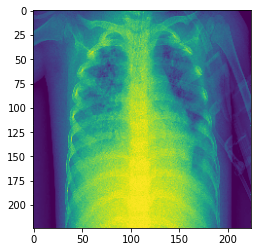

In [ ]:
plt.imshow(xtrain[100])

## Standization data

In [ ]:
mean=xtrain.mean()
std=xtrain.std()
xtrainstad= (xtrain-mean)/std
xteststad= (xtest-mean)/std
xvalstad= (xval-mean)/std

## one hot encoder

In [ ]:
ytrainhot=tf.keras.utils.to_categorical(ytrain)
ytesthot=tf.keras.utils.to_categorical(ytest)
yvalhot=tf.keras.utils.to_categorical(yval)

## add last channel to data

In [ ]:
xtrain_=xtrainstad.reshape(xtrainstad.shape+(1,))
xtest_=xteststad.reshape(xteststad.shape+(1,))
xval_=xvalstad.reshape(xvalstad.shape+(1,))

## Building model

In [ ]:
inpt=tf.keras.layers.Input(xtrain_.shape[1:])
c1=tf.keras.layers.Conv2D(64,(7,7),(2,2))(inpt)
c2=tf.keras.layers.Conv2D(8,(3,3),(2,2))(c1)
f1=tf.keras.layers.Flatten()(c2)
d1=tf.keras.layers.Dense(3,activation="softmax")(f1)

nural_network=tf.keras.Model(inputs=inpt,outputs=d1)

nural_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss=tf.keras.losses.binary_crossentropy
                    ,metrics=["accuracy"])

In [ ]:
history_cnn=nural_network.fit(xtrain_,ytrainhot,
                              validation_data=(xval_,yvalhot)
                              ,batch_size=8,epochs=10)

Epoch 1/10
32/32 [==============================] - 6s 160ms/step - loss: 0.3672 - accuracy: 0.8008 - val_loss: 0.3487 - val_accuracy: 0.8182
Epoch 2/10
32/32 [==============================] - 5s 147ms/step - loss: 0.1597 - accuracy: 0.9323 - val_loss: 0.3400 - val_accuracy: 0.7879
Epoch 3/10
32/32 [==============================] - 5s 147ms/step - loss: 0.0930 - accuracy: 0.9681 - val_loss: 0.4160 - val_accuracy: 0.8485
Epoch 4/10
32/32 [==============================] - 5s 147ms/step - loss: 0.0592 - accuracy: 0.9801 - val_loss: 0.3325 - val_accuracy: 0.8182
Epoch 5/10
32/32 [==============================] - 5s 147ms/step - loss: 0.0337 - accuracy: 0.9960 - val_loss: 0.3444 - val_accuracy: 0.8030
Epoch 6/10
32/32 [==============================] - 5s 147ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.4234 - val_accuracy: 0.8788
Epoch 7/10
32/32 [==============================] - 5s 147ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.4411 - val_accuracy: 0.8788
Epoch 

In [ ]:
def show_results(history,title):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylim([0, 1.1])
    plt.title(title+' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

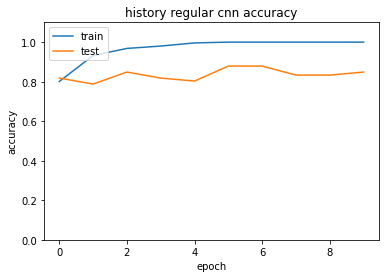

In [ ]:
show_results(history_cnn,"history regular cnn")

## vgg

In [ ]:
vgg_model=tf.keras.applications.VGG16(
    include_top=False,input_shape=(224,224,3))
vgg_model.trainable=False

In [ ]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
inpt=tf.keras.layers.Input(xtrain_.shape[1:])
c1=tf.keras.layers.Conv2D(3,(1,1),padding="same")(inpt)
c2=vgg_model(c1)
c3=tf.keras.layers.Conv2D(3,(1,1),padding="same")(c2)
f1=tf.keras.layers.Flatten()(c3)
d1=tf.keras.layers.Dense(3,activation="softmax")(f1)

nural_network_vgg=tf.keras.Model(inputs=inpt,outputs=d1)

nural_network_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss=tf.keras.losses.binary_crossentropy
                    ,metrics=["accuracy"])

In [ ]:
history_vgg=nural_network_vgg.fit(xtrain_,ytrainhot,
                              validation_data=(xval_,yvalhot)
                              ,batch_size=8,epochs=10)

Epoch 1/10
32/32 [==============================] - 310s 10s/step - loss: 0.6141 - accuracy: 0.4701 - val_loss: 0.5768 - val_accuracy: 0.5606
Epoch 2/10
32/32 [==============================] - 309s 10s/step - loss: 0.4496 - accuracy: 0.8207 - val_loss: 0.4801 - val_accuracy: 0.6970
Epoch 3/10
32/32 [==============================] - 308s 10s/step - loss: 0.3438 - accuracy: 0.9044 - val_loss: 0.4063 - val_accuracy: 0.7273
Epoch 4/10
32/32 [==============================] - 310s 10s/step - loss: 0.2581 - accuracy: 0.9163 - val_loss: 0.3611 - val_accuracy: 0.6818
Epoch 5/10
32/32 [==============================] - 313s 10s/step - loss: 0.2095 - accuracy: 0.9124 - val_loss: 0.3221 - val_accuracy: 0.7576
Epoch 6/10
32/32 [==============================] - 309s 10s/step - loss: 0.1784 - accuracy: 0.9243 - val_loss: 0.3037 - val_accuracy: 0.8030
Epoch 7/10
32/32 [==============================] - 312s 10s/step - loss: 0.1539 - accuracy: 0.9363 - val_loss: 0.2729 - val_accuracy: 0.8333
Epoch 

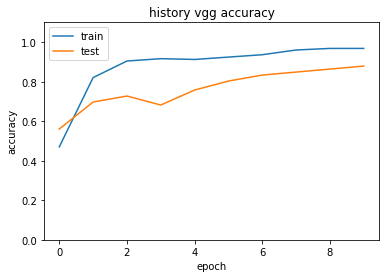

In [ ]:
show_results(history_vgg,"history vgg")

In [ ]:
effecient_model=tf.keras.applications.EfficientNetB0(
    include_top=False,input_shape=(224,224,3))
effecient_model.trainable=False